In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from scipy.stats import spearmanr, mannwhitneyu
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVR
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

Используйте это, если запускаете не в main.ipynb

In [2]:
# PATH = '../analysing_environmental_issues.csv'
# df = pd.read_csv(PATH, sep=",")
# %run remove_outliers/remove_outliers_run.ipynb

# df = hybrid_outlier_handling(df, df.columns[1:-1])
# %run nans_and_columns/initial_data_handlers_run.ipynb

# convert_to_DateTime(df)

# df = nan_to_interpolate(df)
# df = convert_to_category(df)

In [3]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,2174.773113,69.471592,86.295939,403.947055,79.142615,98.477149,56.650281,443.406733,260.425825,94.632289,...,875.801378,109.702281,42.791245,153.465101,20.194840,5.401600,313.945025,22.438208,46.280653,1.483019
std,1273.723768,3.987065,30.279235,61.455302,2.823296,8.888082,7.549161,56.140830,39.718545,4.522556,...,305.646561,2.113204,4.447842,1.585166,2.996097,1.071529,104.223712,1.243364,12.871628,0.499770
min,0.000000,52.630000,19.950000,248.760000,69.020000,79.590000,34.070000,260.220000,134.920000,81.700000,...,134.750000,102.330000,26.610000,148.950000,7.330000,2.350000,65.260000,17.280000,0.710000,1.000000
25%,1059.750000,67.030000,64.817500,353.200000,77.437500,91.450000,52.247500,407.785000,230.072500,93.550000,...,657.092500,108.320000,40.960000,152.347500,18.100000,4.740000,245.287500,21.680000,40.065000,1.000000
50%,2167.500000,70.030000,82.855000,389.402500,78.820000,97.200000,56.070000,435.890000,259.660000,95.530000,...,844.655000,109.220000,44.110000,153.210000,20.510000,5.490000,303.740000,22.580000,47.860000,1.000000
75%,3274.250000,72.330000,105.362500,458.357500,80.810000,103.162500,59.950000,471.097500,290.015000,97.620000,...,1144.502500,110.860000,45.860000,153.830000,22.140000,6.140000,366.120000,23.280000,55.282500,2.000000
max,4399.000000,79.830000,225.570000,764.760000,90.990000,130.930000,82.740000,676.790000,409.860000,109.300000,...,1616.930000,119.280000,53.650000,157.680000,31.460000,7.980000,716.840000,25.480000,98.750000,2.000000


Здесь я копирую из оригинального датафрейма столбцы, вырезанные в ходе предобработки.

In [ ]:
original_df = pd.read_csv("analysing_environmental_issues.csv")

# копируем столбец с опасным газом из оригинального датафрейма
danger_gas = original_df['stage_4_output_danger_gas'].copy()
datetime_column = pd.to_datetime(original_df['DateTime'])

# добавляем столбец в текущий датафрейм
df['stage_4_output_danger_gas'] = danger_gas
df['DateTime'] = datetime_column

In [5]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas
count,4240,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,934.000000
mean,2022-01-01 12:31:55.471698176,69.471592,86.295939,403.947055,79.142615,98.477149,56.650281,443.406733,260.425825,94.632289,...,109.702281,42.791245,153.465101,20.194840,5.401600,313.945025,22.438208,46.280653,1.483019,0.140139
min,2021-01-28 18:00:00,52.630000,19.950000,248.760000,69.020000,79.590000,34.070000,260.220000,134.920000,81.700000,...,102.330000,26.610000,148.950000,7.330000,2.350000,65.260000,17.280000,0.710000,1.000000,0.020000
25%,2021-09-09 23:45:00,67.030000,64.817500,353.200000,77.437500,91.450000,52.247500,407.785000,230.072500,93.550000,...,108.320000,40.960000,152.347500,18.100000,4.740000,245.287500,21.680000,40.065000,1.000000,0.110000
50%,2022-01-31 09:30:00,70.030000,82.855000,389.402500,78.820000,97.200000,56.070000,435.890000,259.660000,95.530000,...,109.220000,44.110000,153.210000,20.510000,5.490000,303.740000,22.580000,47.860000,1.000000,0.140000
75%,2022-06-12 03:15:00,72.330000,105.362500,458.357500,80.810000,103.162500,59.950000,471.097500,290.015000,97.620000,...,110.860000,45.860000,153.830000,22.140000,6.140000,366.120000,23.280000,55.282500,2.000000,0.167500
max,2023-03-21 12:00:00,79.830000,225.570000,764.760000,90.990000,130.930000,82.740000,676.790000,409.860000,109.300000,...,119.280000,53.650000,157.680000,31.460000,7.980000,716.840000,25.480000,98.750000,2.000000,0.340000
std,NaN,3.987065,30.279235,61.455302,2.823296,8.888082,7.549161,56.140830,39.718545,4.522556,...,2.113204,4.447842,1.585166,2.996097,1.071529,104.223712,1.243364,12.871628,0.499770,0.038566


In [6]:
df.isna()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4396,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4397,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4398,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Проведение расчётов

## Создать категорию опасности вредного газа от 1 до 3. 
Низкая опасность (1) показатель до 0.05, средняя(2) - от 0.05 до 0.16, высокая(3) - от 0.16

In [7]:
def get_danger_category(value):
    if pd.isna(value):
        return np.nan
    elif value <= 0.05:
        return 1
    elif value <= 0.16:
        return 2
    else:
        return 3

df['danger_category'] = df['stage_4_output_danger_gas'].apply(get_danger_category)

# названия категорий
category_names = {1: 'Низкая', 2: 'Средняя', 3: 'Высокая'}

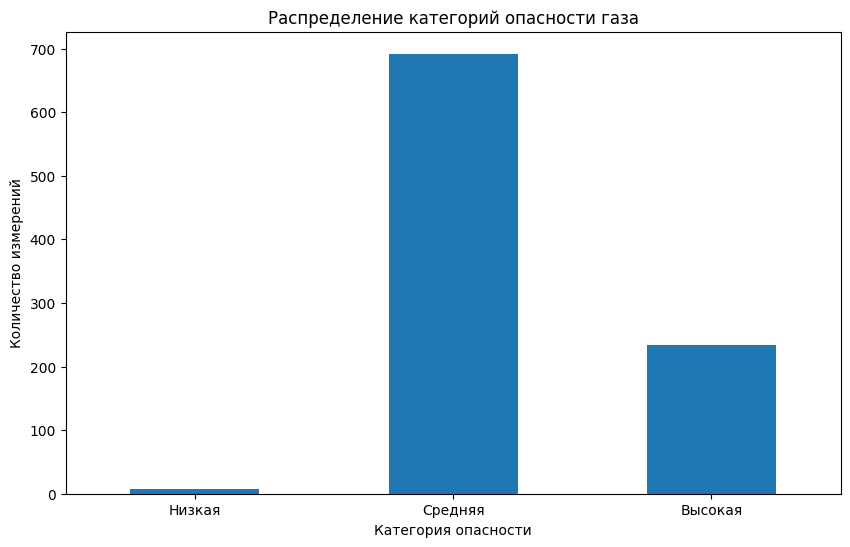

In [8]:
# график распределения категорий
plt.figure(figsize=(10, 6))
df['danger_category'].value_counts().sort_index().plot(kind='bar')
plt.title('Распределение категорий опасности газа')
plt.xlabel('Категория опасности')
plt.ylabel('Количество измерений')
plt.xticks(range(3), ['Низкая', 'Средняя', 'Высокая'])
plt.xticks(rotation=0)
plt.show()

## Создать сводную таблицу изменения параметров сгруппированную по дням без учета номера смены. Выведите суммарные показатели входных параметров. При однотипности парамтра проведите суммирования. Сделайте выводы по расходу ресурсов каждый день. Есть ли периоды, когда компания тратила больше ресурсов?

In [9]:
input_params = [col for col in df.columns if 'input' in col]

# группируем по дням и суммируем входные параметры
daily_summary = df.groupby(df['DateTime'].dt.date)[input_params].sum()


In [10]:
daily_summary.head()

,stage_2_input_water_sum,stage_3_input_pressure,stage_3_input_soft_water,stage_3_input_steam,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water
DateTime,,,,,,,,
2021-01-28,553.40,2.090000,2611.64,4230.27,938.81,117.740000,35.6200,2036.42
2021-01-29,1789.94,5.990000,6978.96,11576.30,2661.56,312.330000,98.2900,5316.36
2021-01-30,549.85,2.020000,2046.81,4128.62,784.46,113.960000,34.6200,1991.15
2021-01-31,1607.20,5.380000,5816.12,12542.45,2193.40,356.290000,108.5059,6161.16
2021-02-01,1821.57,5.713333,6242.88,12160.25,2352.30,355.883333,116.8500,6595.84


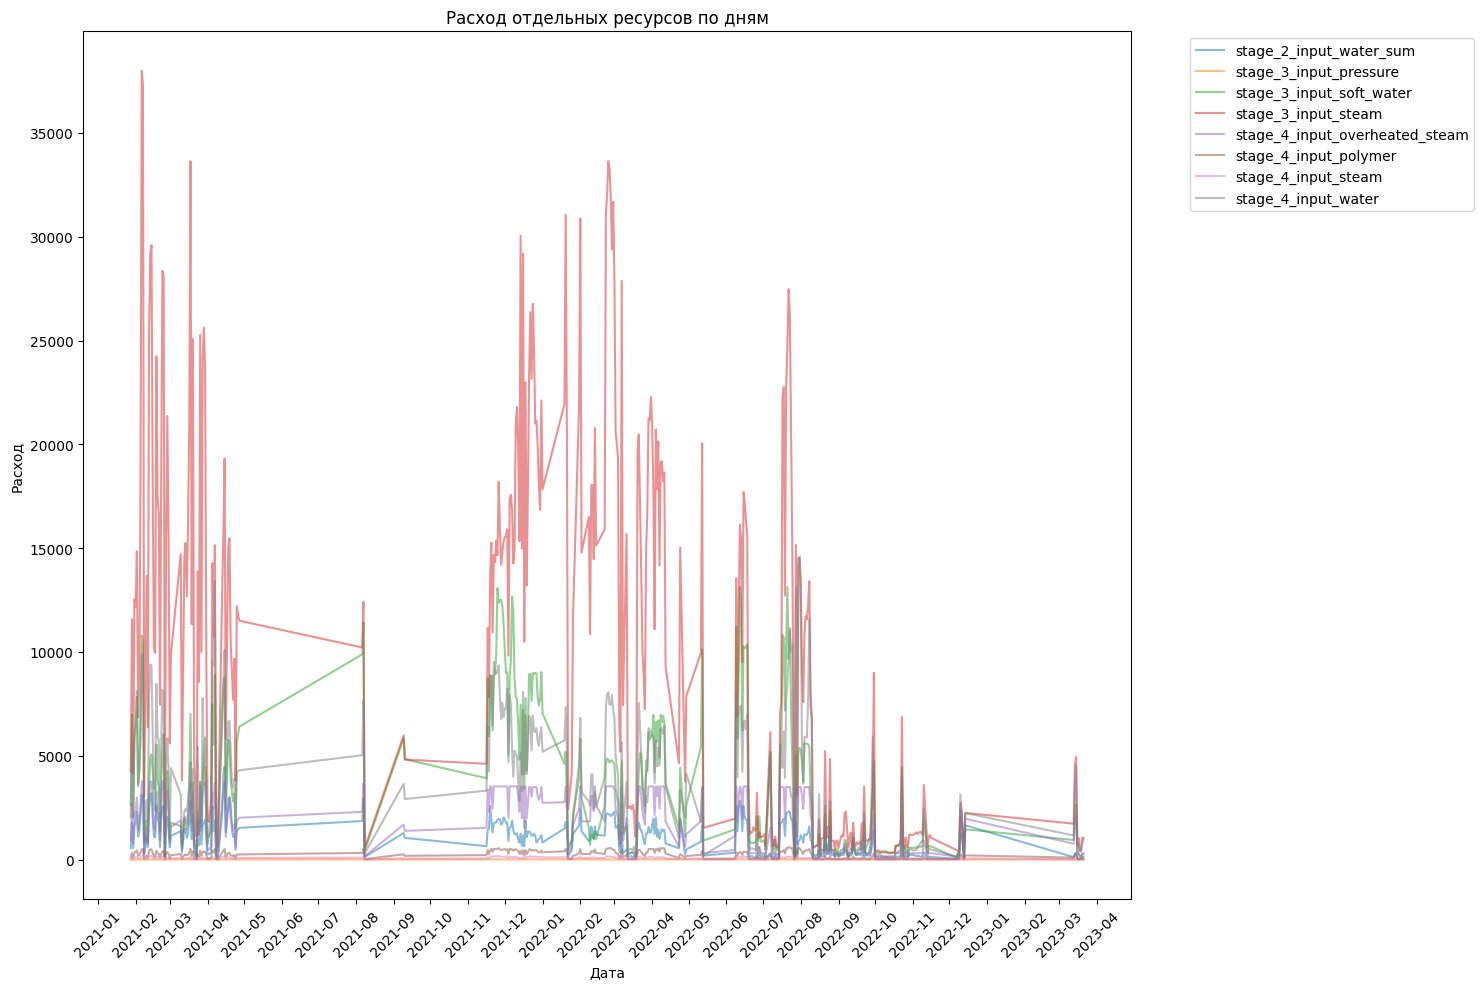

In [11]:
# создаем график для каждого входного параметра
plt.figure(figsize=(15, 10))
for param in input_params:
    plt.plot(daily_summary.index, daily_summary[param], label=param, alpha=0.5)
plt.title('Расход отдельных ресурсов по дням')
plt.xlabel('Дата')
plt.ylabel('Расход')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

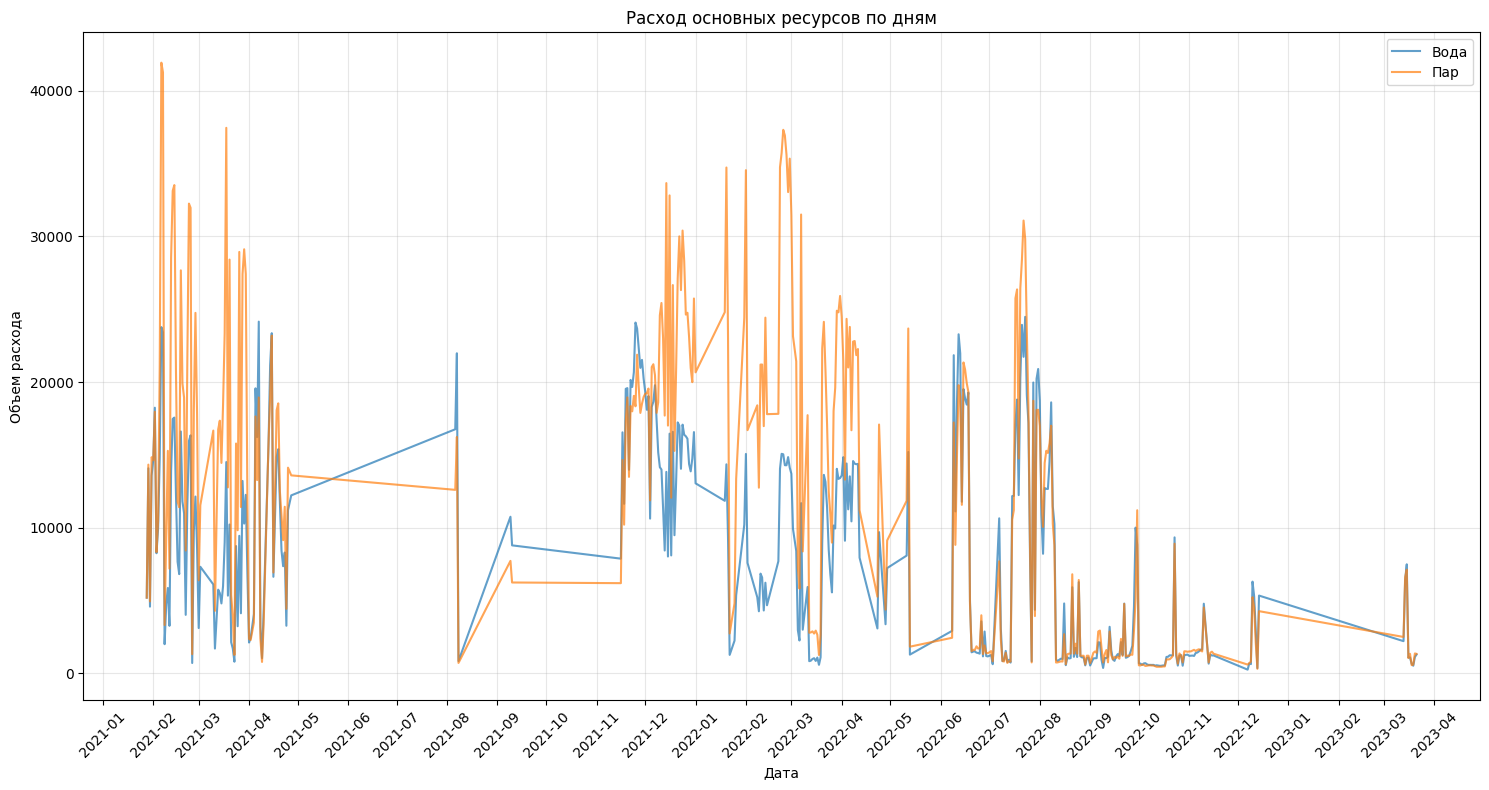

In [12]:
# группируем входные параметры (вода и пар) по типу ресурса
water_params = [col for col in input_params if 'water' in col]
steam_params = [col for col in input_params if 'steam' in col]
other_params = [col for col in input_params if not any(x in col for x in ['water', 'steam'])]

# создаем сводную таблицу по типам ресурсов
daily_resource_types = pd.DataFrame(index=daily_summary.index)

# суммируем однотипные ресурсы
daily_resource_types['total_water'] = daily_summary[water_params].sum(axis=1)
daily_resource_types['total_steam'] = daily_summary[steam_params].sum(axis=1)
daily_resource_types['pressure'] = daily_summary['stage_3_input_pressure']
daily_resource_types['polymer'] = daily_summary['stage_4_input_polymer']

# График общего расхода по типам ресурсов
plt.figure(figsize=(15, 8))
plt.plot(daily_resource_types.index, daily_resource_types['total_water'], label='Вода', alpha=0.7)
plt.plot(daily_resource_types.index, daily_resource_types['total_steam'], label='Пар', alpha=0.7)
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# особой информативности как по мне не несёт, но можно оставить
# plt.plot(daily_resource_types.index, daily_resource_types['pressure'], label='Давление', alpha=0.7) 
# plt.plot(daily_resource_types.index, daily_resource_types['polymer'], label='Полимеры', alpha=0.7)

plt.title('Расход основных ресурсов по дням')
plt.xlabel('Дата')
plt.ylabel('Объем расхода')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Мне показалось, что не будет лишним также создать отдельные группы под потребление на каждом этапе производства

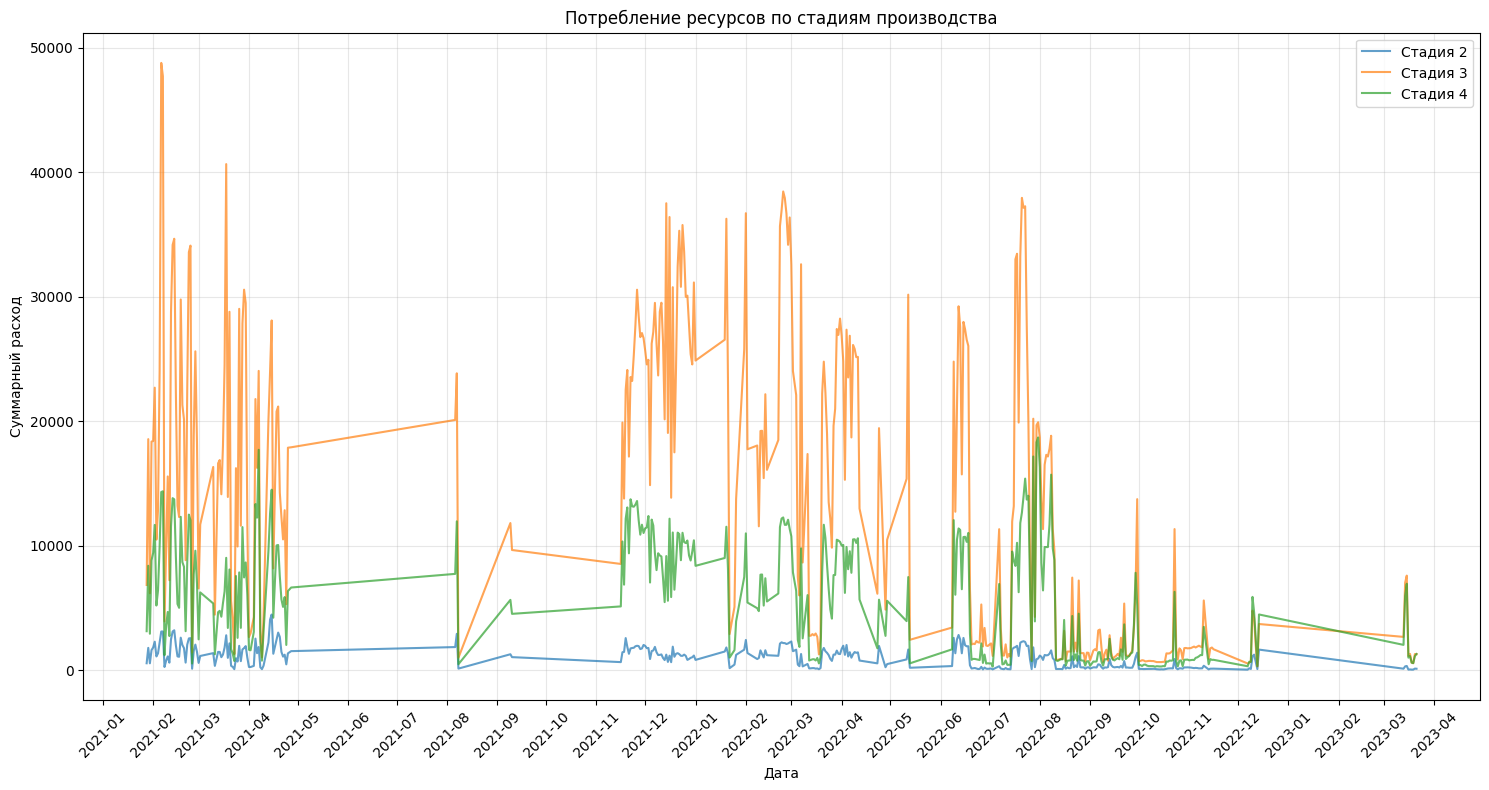

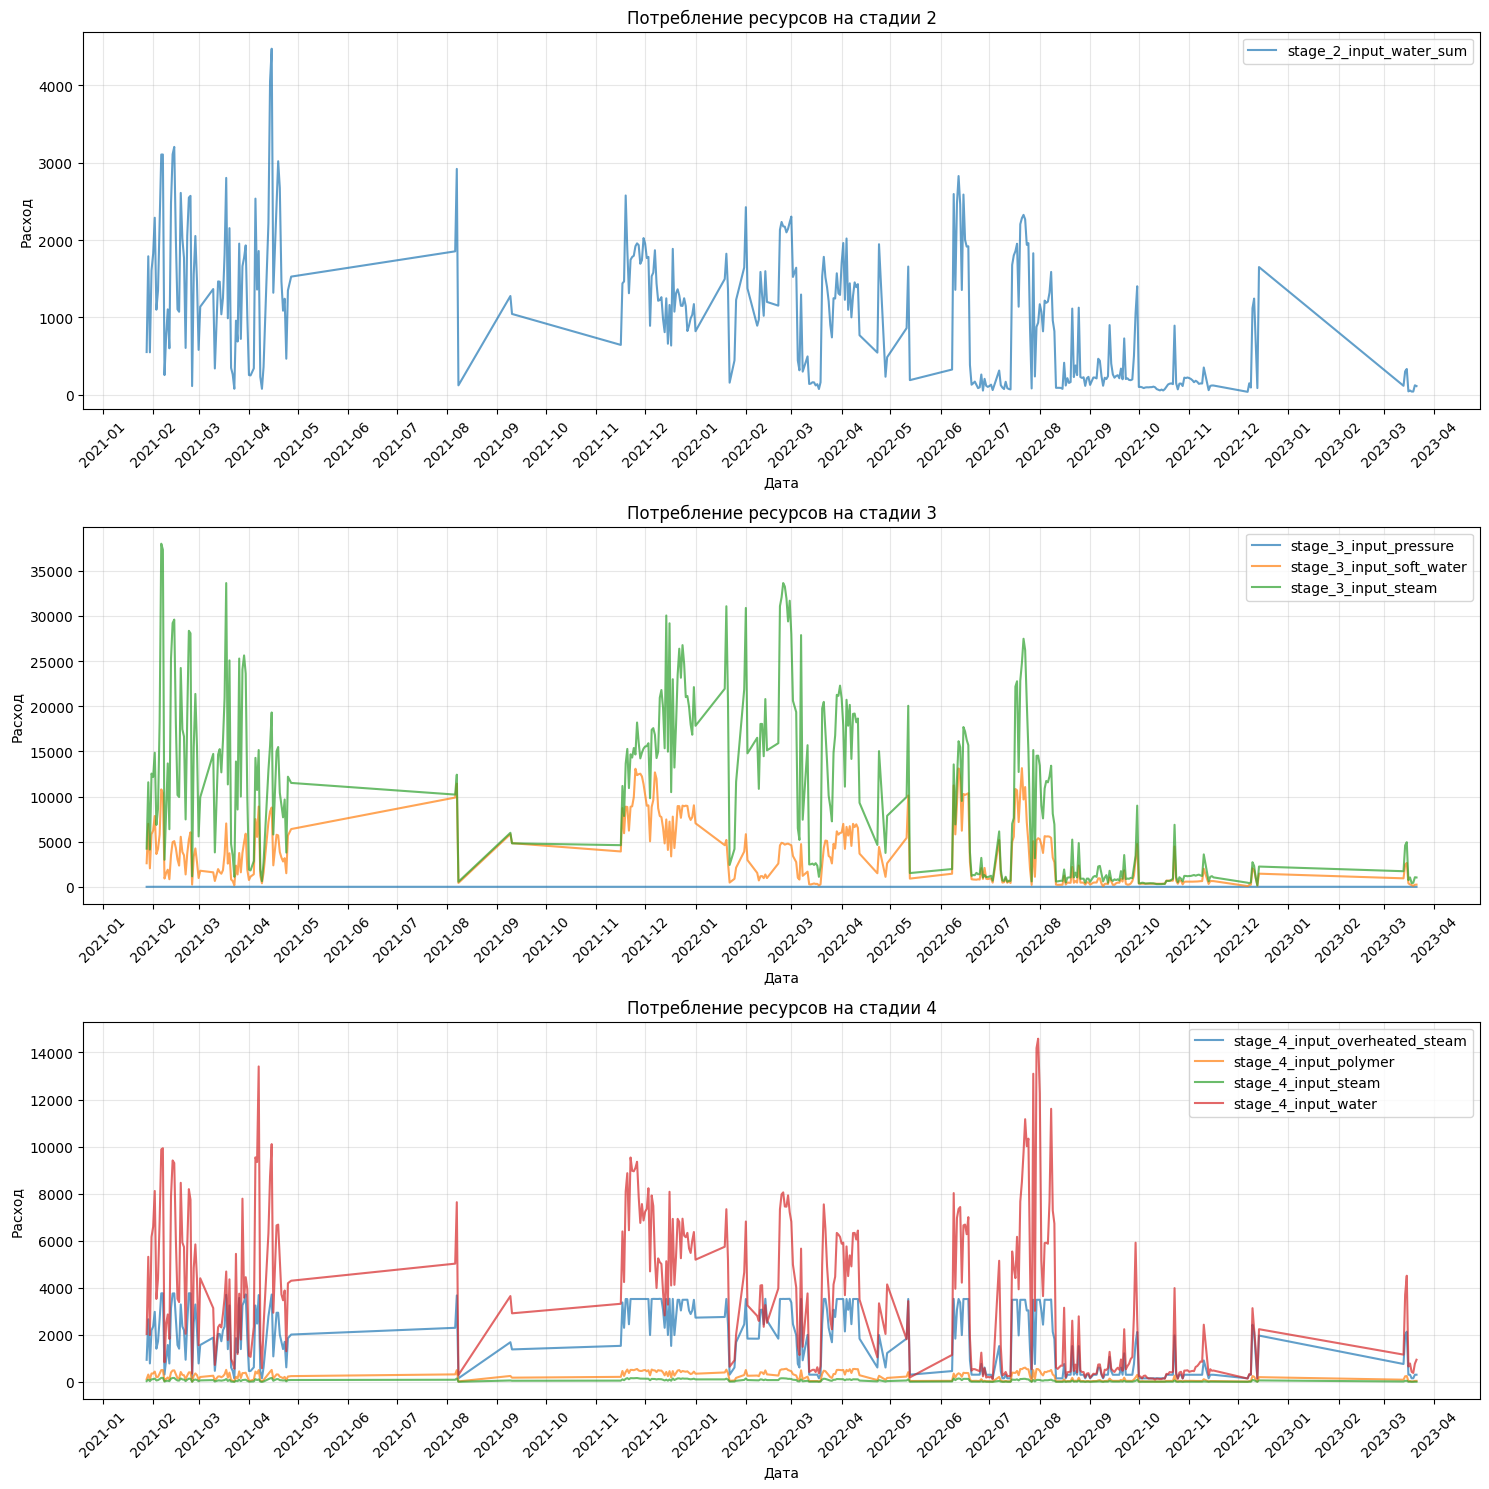


статистика расхода по стадиям:
           stage_2       stage_3       stage_4
count   371.000000    371.000000    371.000000
mean    986.239299  13582.481842   5634.360746
std     841.814295  11936.234400   4648.124993
min      39.710000    303.740000    274.540000
25%     191.990000   1810.640000    871.043333
50%     905.480000  11701.120000   5193.070000
75%    1574.710000  24036.705000   9687.190250
max    4470.166667  48792.833333  18700.160000


In [13]:

# группировка параметров по стадиям
stage_2_params = [col for col in input_params if 'stage_2' in col]
stage_3_params = [col for col in input_params if 'stage_3' in col]
stage_4_params = [col for col in input_params if 'stage_4' in col]

# создаем сводные таблицы по стадиям
daily_stages = pd.DataFrame(index=daily_summary.index)
daily_stages['stage_2'] = daily_summary[stage_2_params].sum(axis=1)
daily_stages['stage_3'] = daily_summary[stage_3_params].sum(axis=1)
daily_stages['stage_4'] = daily_summary[stage_4_params].sum(axis=1)

#  график по каждой стадии, суммарное потребление НЕ разделённое на категории (вода/пар/полимеры)
plt.figure(figsize=(15, 8))
for stage in daily_stages.columns:
    plt.plot(daily_stages.index, daily_stages[stage], label=f'Стадия {stage[-1]}', alpha=0.7)
plt.title('Потребление ресурсов по стадиям производства')
plt.xlabel('Дата')
plt.ylabel('Суммарный расход')
plt.legend()
plt.grid(True, alpha=0.3)
# цена деления - месяц
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 1, figsize=(15, 15))
#  график по каждой стадии,  потребление по категориям (вода/пар/полимеры)
for idx, (stage_name, params) in enumerate(zip(['stage_2', 'stage_3', 'stage_4'], [stage_2_params, stage_3_params, stage_4_params])):
    for param in params:
        axes[idx].plot(daily_summary.index, daily_summary[param], label=param, alpha=0.7)
    axes[idx].set_title(f'Потребление ресурсов на стадии {stage_name[-1]}')
    axes[idx].set_xlabel('Дата')
    axes[idx].set_ylabel('Расход')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    # устанавливаем цену деления
    axes[idx].xaxis.set_major_locator(MonthLocator())
    axes[idx].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# стата по стадиям
print("\nстатистика расхода по стадиям:")
print(daily_stages.describe())


Находим дни с максимальным суммарным потреблением. Пока что видно, что наиболее ресурсозатратным периодом является первая половина 2021. (Однако нельзя игнорировать факт, что она также является наиболее задокументированной).

In [14]:
# дни с максимальным потреблением по стадиям
print("\n 10 дней с максимальным потреблением")
for stage in daily_stages.columns:
    peak_days = daily_stages[stage].nlargest(10)
    print(f"\n{stage}:")
    print(peak_days)


 10 дней с максимальным потреблением

stage_2:
DateTime
2021-04-15    4470.166667
2021-04-14    4050.390000
2021-02-14    3202.216667
2021-02-13    3107.296667
2021-02-07    3104.140000
2021-02-06    3103.940000
2021-04-19    3017.613333
2021-08-07    2918.280000
2022-06-12    2826.180000
2021-03-18    2802.010000
Name: stage_2, dtype: float64

stage_3:
DateTime
2021-02-06    48792.833333
2021-02-07    47724.980000
2021-03-18    40660.990000
2022-02-24    38460.160000
2022-07-21    37947.996667
2022-02-25    37936.980000
2021-12-14    37514.820000
2022-07-23    37272.753333
2022-07-22    37151.230000
2022-02-23    36928.866667
Name: stage_3, dtype: float64

stage_4:
DateTime
2022-07-31    18700.160000
2022-07-30    18305.760000
2021-04-07    17703.620000
2022-07-28    17167.630000
2022-08-01    16320.820000
2022-08-08    15708.140000
2022-07-23    15390.185533
2021-04-15    14497.260000
2021-02-07    14370.067833
2021-02-06    14312.123333
Name: stage_4, dtype: float64


In [15]:
daily_stages.head(20)

,stage_2,stage_3,stage_4
DateTime,,,
2021-01-28,553.400000,6844.000000,3128.590000
2021-01-29,1789.940000,18561.250000,8388.540000
2021-01-30,549.850000,6177.450000,2924.190000
2021-01-31,1607.200000,18363.950000,8819.355900
2021-02-01,1821.570000,18408.843333,9420.873333
2021-02-02,2287.780000,22697.506667,11669.795500
2021-02-03,1100.090000,10485.740000,5193.070000
2021-02-04,1349.810000,12870.520000,6408.040000
2021-02-05,2208.403333,24052.480000,9959.650000


Попробуем проанализировать периоды повышенного потребления ресурсов. Для этого я считаю "средний расход" за всё время (увы, работаем с тем, что есть...)
Смотрю, насколько сильно реальный расход отличается от среднего и определяю порог высокого и критично выского потребления, используя Z-score (мера относительного разброса наблюдаемого или измеренного значения, которая показывает сколько стандартных отклонений составляет его разброс относительного среднего значения).
Если расход сильно выше среднего несколько дней подряд - это явно проблема и, т.н "тренд", следовательно - стоит уделить этому периоду особое внимание.

In [16]:
def analyze_daily_resource_usage(daily_summary):

    daily_summary.index = pd.to_datetime(daily_summary.index)
    
    # рассчитываем общее потребление ресурсов за день
    daily_total = daily_summary.sum(axis=1)
    
    mean_usage = daily_total.mean()
    std_usage = daily_total.std()
    
    # определяем пороги для категорий потребления (используем z-score)
    high_consuming = mean_usage + std_usage
    very_high_consuming = mean_usage + 2*std_usage
    
    # категоризируем дни по уровню потребления
    use_category = pd.Series(index=daily_total.index, dtype='object')
    use_category[daily_total <= mean_usage] = 'Normal'
    use_category[(daily_total > mean_usage) & (daily_total <= high_consuming)] = 'Above Average'
    use_category[(daily_total > high_consuming) & (daily_total <= very_high_consuming)] = 'High'
    use_category[daily_total > very_high_consuming] = 'Very High'
    
    # найдем периоды повышенного потребления
    high_usage_periods = []
    current_period = []
    
    for date, category in use_category.items():
        if category in ['High', 'Very High']:
            current_period.append(date)
        elif len(current_period) > 0:
            if len(current_period) >= 2:  # период 2 дня
                high_usage_periods.append({
                    'start': min(current_period),
                    'end': max(current_period),
                    'duration': len(current_period),
                    'average_usage': daily_total[current_period].mean()
                })
            current_period = []
            
    # добавим последний период, если он существует
    if len(current_period) >= 2:
        high_usage_periods.append({
            'start': min(current_period),
            'end': max(current_period),
            'duration': len(current_period),
            'average_usage': daily_total[current_period].mean()
        })
    
    # метод ресэмпл (определение из гугла):
    # О методе .resample() можно думать как о группировке по времени, за которым следует метод агрегирования для каждой из его групп.
    # Другими словами - это GroupBy основанный на времени. Его можно использовать непосредственно из объектов обычной группировки DataFrameGroupBy.

    monthly_avg = daily_total.resample('M').mean()
    monthly_trend = monthly_avg.pct_change()
    
    
    
    return {'daily_stats': {
            'mean': mean_usage,
            'std': std_usage,
            'min': daily_total.min(),
            'max': daily_total.max(),
            'median': daily_total.median()
        }, 'use_category': use_category, 'high_usage_periods': high_usage_periods, 'monthly_trend': monthly_trend, 'daily_total': daily_total
    }


def print_analysis_results(results): #красивый вывод результата
    print("\n___ Статистика ежедневного потребления ресурсов: ___\n")
    print('------------------------------------------------------------')
    print(f"Среднее потребление: {results['daily_stats']['mean']:.2f}")
    print(f"Стандартное отклонение: {results['daily_stats']['std']:.2f}")
    print(f"Минимальное потребление: {results['daily_stats']['min']:.2f}")
    print(f"Максимальное потребление: {results['daily_stats']['max']:.2f}")
    print(f"Медианное потребление: {results['daily_stats']['median']:.2f}")
    print('------------------------------------------------------------')  

    print("\n___ Периоды повышенного потребления: ___")
    for period in results['high_usage_periods']:
        print(f"\nПериод: {period['start'].date()} - {period['end'].date()}")
        print(f"Длительность: {period['duration']} дней")
        print(f"Среднее потребление: {period['average_usage']:.2f}")
    print('------------------------------------------------------------')    



results = analyze_daily_resource_usage(daily_summary)
print_analysis_results(results)


___ Статистика ежедневного потребления ресурсов: ___

------------------------------------------------------------
Среднее потребление: 20203.08
Стандартное отклонение: 16989.35
Минимальное потребление: 708.38
Максимальное потребление: 66208.90
Медианное потребление: 18565.93
------------------------------------------------------------

___ Периоды повышенного потребления: ___

Период: 2021-02-06 - 2021-02-07
Длительность: 2 дней
Среднее потребление: 65704.04

Период: 2021-02-12 - 2021-02-14
Длительность: 3 дней
Среднее потребление: 48489.00

Период: 2021-02-23 - 2021-02-24
Длительность: 2 дней
Среднее потребление: 48678.12

Период: 2021-03-28 - 2021-03-30
Длительность: 3 дней
Среднее потребление: 40291.48

Период: 2021-04-14 - 2021-04-15
Длительность: 2 дней
Среднее потребление: 43816.52

Период: 2021-11-19 - 2021-11-20
Длительность: 2 дней
Среднее потребление: 38171.18

Период: 2021-11-22 - 2021-12-03
Длительность: 12 дней
Среднее потребление: 40373.42

Период: 2021-12-05 - 2021-12-

C:\Users\user\AppData\Local\Temp\ipykernel_2652\3685374072.py:52: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = daily_total.resample('M').mean()
C:\Users\user\AppData\Local\Temp\ipykernel_2652\3685374072.py:53: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_trend = monthly_avg.pct_change()


**В итоге, следующие периоды имели тренд на повышенное потребление суммарных ресурсов:**

1) 2021-11-22 - 2021-12-03 (12 дней)
2) 2021-12-21 - 2021-12-28 (8 дней)
3) 2022-02-22 - 2022-03-01 (8 дней)

Немного ранее мы заметили, что сильные скачки потребления приходились на первую половину 2021 (опираясь на максимальные значения потребления). Они тоже есть в списке периодов повышенного потребления! Однако их длительность не превышает двух дней, т.е есть смысл предполагать, что имели место быть ВСПЫШКИ повышенного потребления ресурсов.

## Создать сводную таблицу изменения категории опасности сгруппированную по месяцам. Выводите ту категорию, которая была чаще всего в месяца. Есть ли в течении года периоды, когда производство было самым опасным?


In [17]:
# создаем сводную таблицу изменения категории опасности (группировка по месяцам)
monthly_summary = df.groupby(df['DateTime'].dt.strftime('%Y-%m')).agg({'danger_category': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan, 'stage_4_output_danger_gas': 'mean', 'DateTime': 'count'
}).rename(columns={'danger_category': 'most_common_category',
    'stage_4_output_danger_gas': 'avg_danger_gas',
    'DateTime': 'count' # важный столбец!
})


monthly_summary['most_common_category'] = monthly_summary['most_common_category'].map(category_names)



In [18]:
print("Сводная таблица по месяцам:")
monthly_summary


Сводная таблица по месяцам:


,most_common_category,avg_danger_gas,count
DateTime,,,
2021-01,Средняя,0.156667,42
2021-02,Средняя,0.146145,418
2021-03,Средняя,0.113651,289
2021-04,Средняя,0.154909,260
2021-08,Средняя,0.091250,40
2021-09,Средняя,0.116667,20
2021-11,Средняя,0.149811,316
2021-12,Средняя,0.151651,641
2022-01,Средняя,0.150000,108


**После группировки данных по месяцу, видны некоторые особенности распределения количества наблюдений, в частности:**

1. полностью отсутствуют данные за некоторые месяцы
2. крупный разброс в количестве измерений по месяцам (варьируется от 20 до 418.)

**Что с этим делать?**
Есть вариант добавить "веса" для тех месяцев, что более детально отображают реальное положение дел на производстве (наблюдений больше), либо как-нибудь поделить временные промежутки, чтобы "уровнять" данные... Не знаю пока, в общем

In [19]:
# также можем добавить проверку распределения категорий опасности по каждому месяцу
print("\nРаспределение категорий по месяцам:")
monthly_distribution = df.groupby(df['DateTime'].dt.strftime('%Y-%m'))['danger_category'].value_counts()
for month_year, category_counts in monthly_distribution.groupby(level=0):
    print(month_year)
    print(category_counts)
    print("----------------------------")


Распределение категорий по месяцам:
2021-01
DateTime  danger_category
2021-01   2.0                6
          3.0                3
Name: count, dtype: int64
----------------------------
2021-02
DateTime  danger_category
2021-02   2.0                61
          3.0                22
Name: count, dtype: int64
----------------------------
2021-03
DateTime  danger_category
2021-03   2.0                59
          1.0                 2
          3.0                 2
Name: count, dtype: int64
----------------------------
2021-04
DateTime  danger_category
2021-04   2.0                38
          3.0                17
Name: count, dtype: int64
----------------------------
2021-08
DateTime  danger_category
2021-08   2.0                8
Name: count, dtype: int64
----------------------------
2021-09
DateTime  danger_category
2021-09   2.0                3
Name: count, dtype: int64
----------------------------
2021-11
DateTime  danger_category
2021-11   2.0                37
          3.0  

**"Рекордсмены" по абсолютному (!!! т.е без учета численности выборки и тд) количеству наблюдений с отметкой о высокой опасности газа:**

1) 2021-02 (22)
2) 2021-12 (40)
3) 2022-03 (27)

## Для каждой категории вывести среднее значение каждого параметра (без учета номера смены). Есть ли заметные отличия типа категории?

**Нам необходимо вывести среднее значение каждого параметра без учета смены. Для наглядности сделаем табличку средних значений (и табличку динамики в процентах, т.е как меняется ср. значение с категорией) и построим графики**

СТАДИЯ 1


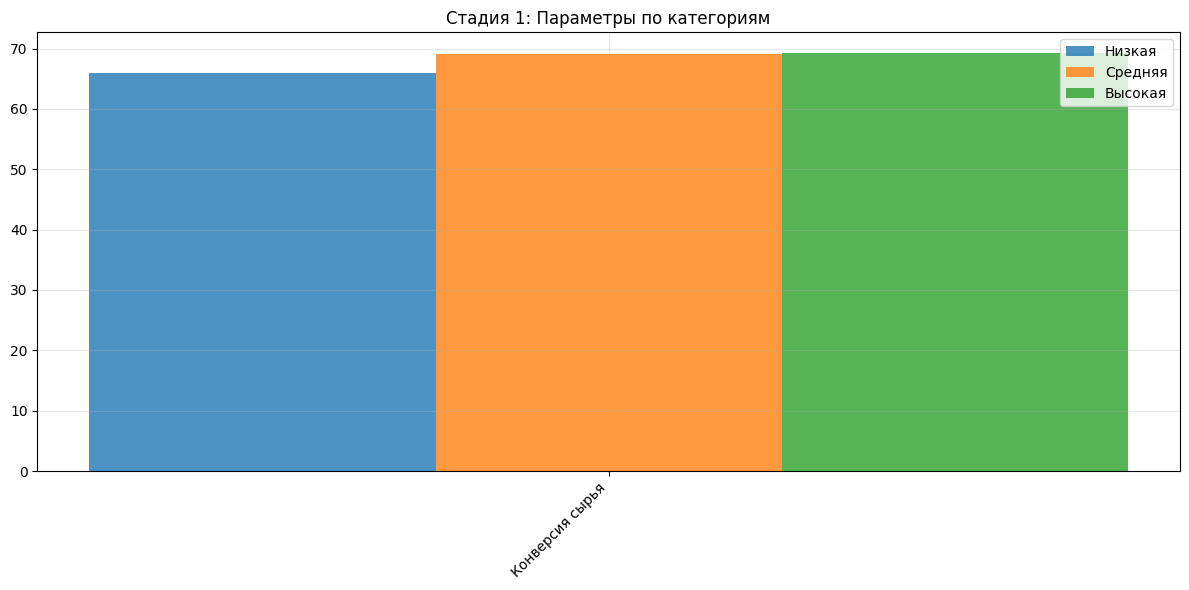


Конверсия сырья:
Низкая категория: 65.94
Средняя категория: 69.05 (изменение: 4.7%)
Высокая категория: 69.24 (изменение: 0.3%)
СТАДИЯ 2


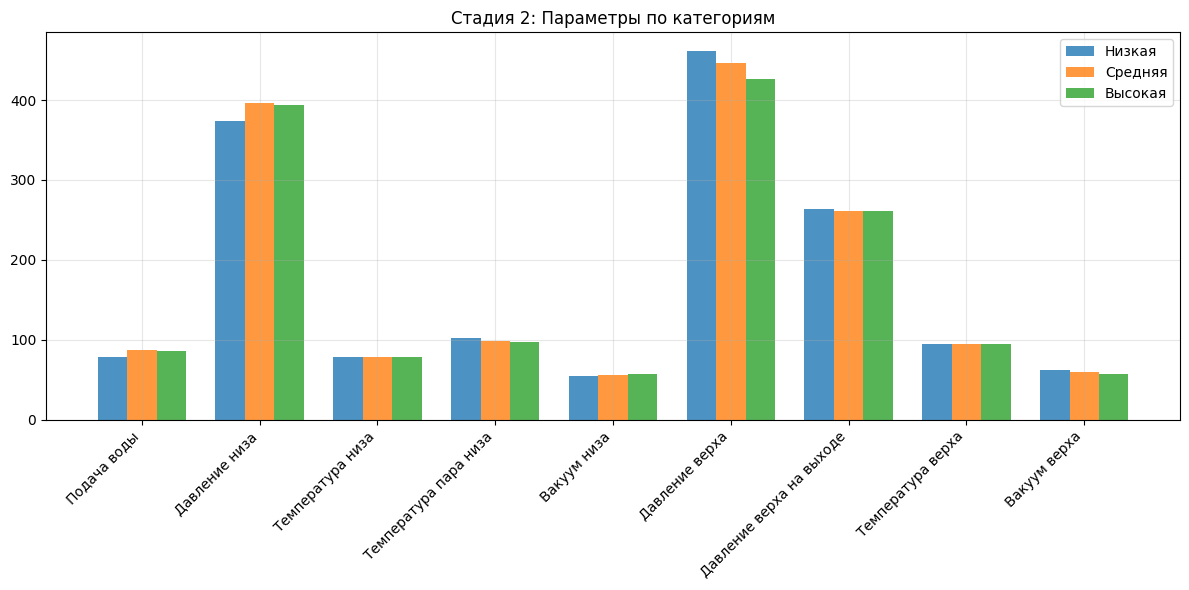


Подача воды:
Низкая категория: 78.85
Средняя категория: 87.64 (изменение: 11.1%)
Высокая категория: 85.58 (изменение: -2.4%)
!!! Значимое изменение !!!

Давление низа:
Низкая категория: 374.11
Средняя категория: 396.36 (изменение: 5.9%)
Высокая категория: 393.56 (изменение: -0.7%)
!!! Значимое изменение !!!

Температура низа:
Низкая категория: 78.38
Средняя категория: 78.97 (изменение: 0.8%)
Высокая категория: 78.73 (изменение: -0.3%)

Температура пара низа:
Низкая категория: 102.18
Средняя категория: 98.15 (изменение: -3.9%)
Высокая категория: 97.58 (изменение: -0.6%)

Вакуум низа:
Низкая категория: 54.06
Средняя категория: 56.44 (изменение: 4.4%)
Высокая категория: 56.93 (изменение: 0.9%)

Давление верха:
Низкая категория: 461.62
Средняя категория: 445.81 (изменение: -3.4%)
Высокая категория: 426.57 (изменение: -4.3%)

Давление верха на выходе:
Низкая категория: 263.26
Средняя категория: 261.06 (изменение: -0.8%)
Высокая категория: 261.07 (изменение: 0.0%)

Температура верха:
Низкая

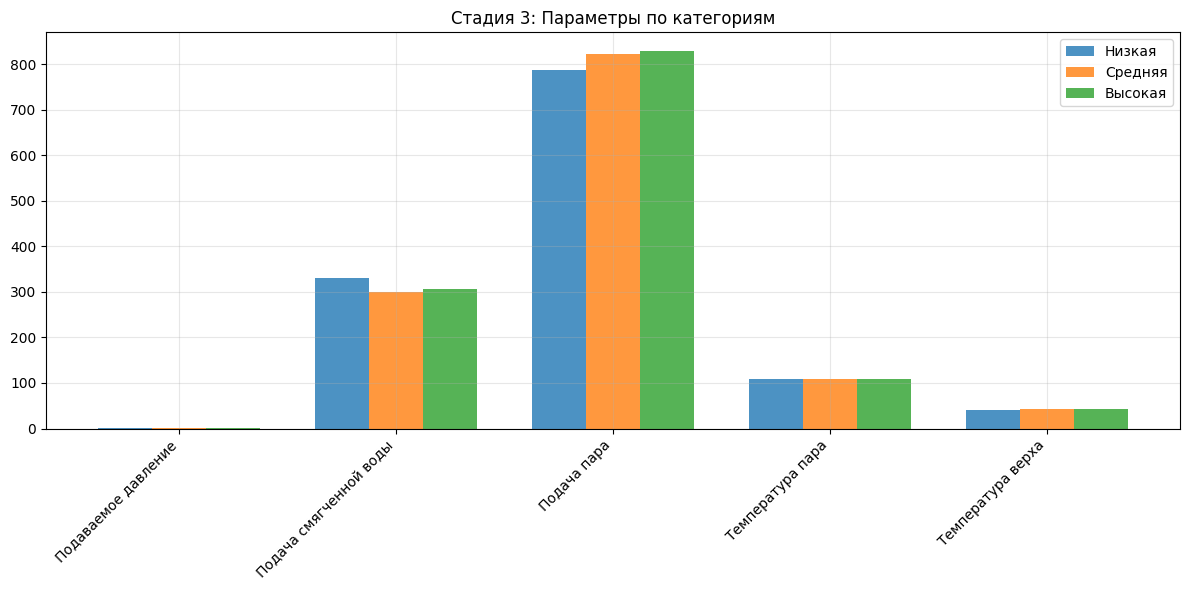


Подаваемое давление:
Низкая категория: 0.34
Средняя категория: 0.33 (изменение: -2.9%)
Высокая категория: 0.32 (изменение: -3.0%)

Подача смягченной воды:
Низкая категория: 330.61
Средняя категория: 300.38 (изменение: -9.1%)
Высокая категория: 305.72 (изменение: 1.8%)
!!! Значимое изменение !!!

Подача пара:
Низкая категория: 786.35
Средняя категория: 821.77 (изменение: 4.5%)
Высокая категория: 828.52 (изменение: 0.8%)

Температура пара:
Низкая категория: 109.07
Средняя категория: 109.26 (изменение: 0.2%)
Высокая категория: 109.69 (изменение: 0.4%)

Температура верха:
Низкая категория: 41.44
Средняя категория: 42.33 (изменение: 2.1%)
Высокая категория: 42.43 (изменение: 0.2%)
СТАДИЯ 4


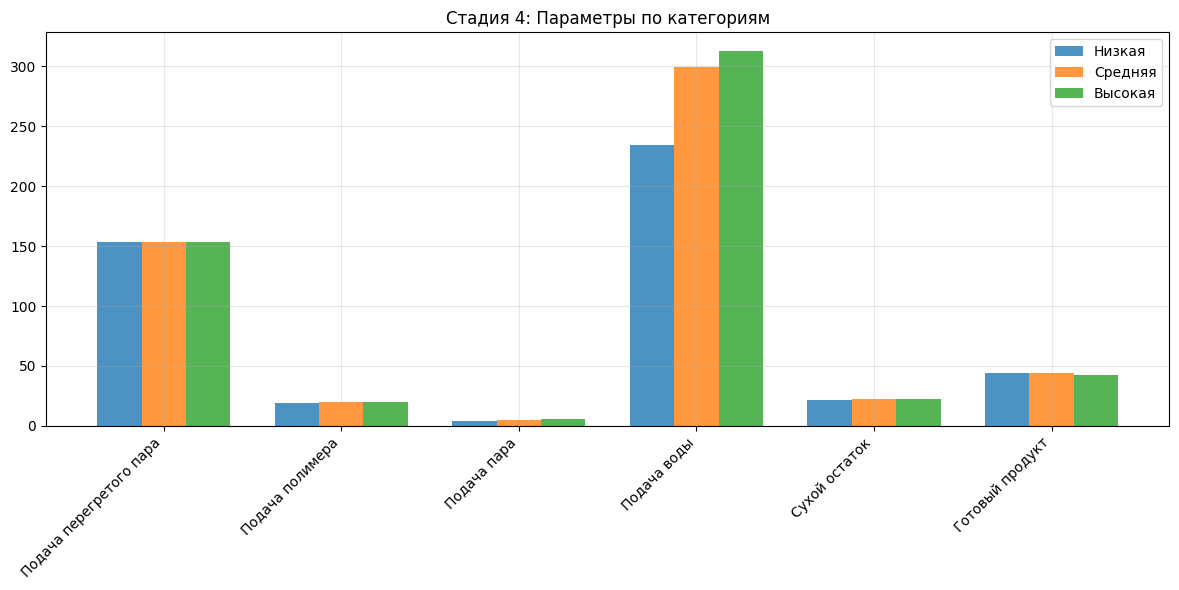


Подача перегретого пара:
Низкая категория: 153.17
Средняя категория: 153.36 (изменение: 0.1%)
Высокая категория: 153.21 (изменение: -0.1%)

Подача полимера:
Низкая категория: 18.75
Средняя категория: 20.11 (изменение: 7.3%)
Высокая категория: 20.17 (изменение: 0.3%)
!!! Значимое изменение !!!

Подача пара:
Низкая категория: 4.49
Средняя категория: 5.28 (изменение: 17.6%)
Высокая категория: 5.57 (изменение: 5.5%)
!!! Значимое изменение !!!

Подача воды:
Низкая категория: 234.39
Средняя категория: 299.73 (изменение: 27.9%)
Высокая категория: 312.67 (изменение: 4.3%)
!!! Значимое изменение !!!

Сухой остаток:
Низкая категория: 21.27
Средняя категория: 22.27 (изменение: 4.7%)
Высокая категория: 22.51 (изменение: 1.1%)

Готовый продукт:
Низкая категория: 44.03
Средняя категория: 43.99 (изменение: -0.1%)
Высокая категория: 42.10 (изменение: -4.3%)


In [21]:
def analyze_data(df, category_names):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    parameters = [col for col in numeric_cols if col not in ['work_shift', 'stage_4_output_danger_gas', 'danger_category']]
    
    # создаем базовую таблицу средних значений
    means = df.groupby('danger_category')[parameters].mean().round(2)
    means.index = means.index.map(category_names)
    
    # изменения процентные
    changes = pd.DataFrame(index=parameters)
    changes['Low_to_Med_%'] = ((means.loc['Средняя'] / means.loc['Низкая'] - 1) * 100).round(1)
    changes['Med_to_High_%'] = ((means.loc['Высокая'] / means.loc['Средняя'] - 1) * 100).round(1)
    
    # не суди да не судим будешь...
    param_description = {
        'stage_1_output_konv_avd': 'Стадия 1 / Конверсия сырья',
        'stage_2_input_water_sum': 'Стадия 2 / Подача воды',
        'stage_2_output_bottom_pressure': 'Стадия 2 / Давление низа',
        'stage_2_output_bottom_temp': 'Стадия 2 / Температура низа',
        'stage_2_output_bottom_temp_hum_steam': 'Стадия 2 / Температура пара низа',
        'stage_2_output_bottom_vacuum': 'Стадия 2 / Вакуум низа',
        'stage_2_output_top_pressure': 'Стадия 2 / Давление верха',
        'stage_2_output_top_pressure_at_end': 'Стадия 2 / Давление верха на выходе',
        'stage_2_output_top_temp': 'Стадия 2 / Температура верха',
        'stage_2_output_top_vacuum': 'Стадия 2 / Вакуум верха',
        'stage_3_input_pressure': 'Стадия 3 / Подаваемое давление',
        'stage_3_input_soft_water': 'Стадия 3 / Подача смягченной воды',
        'stage_3_input_steam': 'Стадия 3 / Подача пара',
        'stage_3_output_temp_hum_steam': 'Стадия 3 / Температура пара',
        'stage_3_output_temp_top': 'Стадия 3 / Температура верха',
        'stage_4_input_overheated_steam': 'Стадия 4 / Подача перегретого пара',
        'stage_4_input_polymer': 'Стадия 4 / Подача полимера',
        'stage_4_input_steam': 'Стадия 4 / Подача пара',
        'stage_4_input_water': 'Стадия 4 / Подача воды',
        'stage_4_output_dry_residue_avg': 'Стадия 4 / Сухой остаток',
        'stage_4_output_product': 'Стадия 4 / Готовый продукт'
    }
    
    # переименовываем параметры
    result = means.copy()
    result.columns = [param_description[col] for col in parameters]
    result = result.T
    
    changes.index = [param_description[col] for col in parameters]
    
    # пробегаем по стадиям и делаем анализ категорий
    for stage in range(1, 5):
        stage_params = [p for p in result.index if f'Стадия {stage}' in p]
        if stage_params:
            print("===========================================")
            print(f"СТАДИЯ {stage}")
            print("===========================================")
            
            # график
            plt.figure(figsize=(12, 6))
            x = np.arange(len(stage_params))
            width = 0.25
            
            plt.bar(x - width, result.loc[stage_params, 'Низкая'], width, label='Низкая', alpha=0.8)
            plt.bar(x, result.loc[stage_params, 'Средняя'], width, label='Средняя', alpha=0.8)
            plt.bar(x + width, result.loc[stage_params, 'Высокая'], width, label='Высокая', alpha=0.8)
            
            plt.title(f'Стадия {stage}: Параметры по категориям')
            plt.xticks(x, [p.split('/')[1].strip() for p in stage_params], rotation=45, ha='right')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # анализ каждого параметра
            for param in stage_params:
                low_val = result.loc[param, 'Низкая']
                med_val = result.loc[param, 'Средняя']
                high_val = result.loc[param, 'Высокая']
                
                low_to_med = ((med_val/low_val) -1)* 100
                med_to_high = ((high_val/med_val)-1)*100
                
                print(f"\n{param.split('/')[1].strip()}:")
                print(f"Низкая категория: {low_val:.2f}")
                print(f"Средняя категория: {med_val:.2f} (изменение: {low_to_med:.1f}%)")
                print(f"Высокая категория: {high_val:.2f} (изменение: {med_to_high:.1f}%)")
                
                if abs(low_to_med) > 5 or abs(med_to_high) > 5:
                    print("!!! Значимое изменение !!!")
    
    return result, changes


result, changes = analyze_data(df, category_names)

**Таблицы:**

In [22]:
changes

,Low_to_Med_%,Med_to_High_%
Стадия 1 / Конверсия сырья,4.7,0.3
Стадия 2 / Подача воды,11.1,-2.4
Стадия 2 / Давление низа,5.9,-0.7
Стадия 2 / Температура низа,0.8,-0.3
Стадия 2 / Температура пара низа,-3.9,-0.6
Стадия 2 / Вакуум низа,4.4,0.9
Стадия 2 / Давление верха,-3.4,-4.3
Стадия 2 / Давление верха на выходе,-0.8,0.0
Стадия 2 / Температура верха,-0.0,0.7
Стадия 2 / Вакуум верха,-4.0,-4.5


In [23]:
result

danger_category,Низкая,Средняя,Высокая
Стадия 1 / Конверсия сырья,65.94,69.05,69.24
Стадия 2 / Подача воды,78.85,87.64,85.58
Стадия 2 / Давление низа,374.11,396.36,393.56
Стадия 2 / Температура низа,78.38,78.97,78.73
Стадия 2 / Температура пара низа,102.18,98.15,97.58
Стадия 2 / Вакуум низа,54.06,56.44,56.93
Стадия 2 / Давление верха,461.62,445.81,426.57
Стадия 2 / Давление верха на выходе,263.26,261.06,261.07
Стадия 2 / Температура верха,94.42,94.40,95.07
Стадия 2 / Вакуум верха,61.63,59.18,56.52


**Анализируя данные, можно выделить основные моменты:**

**1) Наиболее важные изменения происходят на 4-й стадии производства:**

1. Подача воды увеличивается (+28%)! при средней опасности
2. Подача пара возрастает на 18%
3. Подача полимера повышается на 7%
4. Количество готового продукта падает на 4% при высокой опасности производства!!!


**2) На 2 стадии:**

1. Подача воды увеличивается на 11%
2. Давление низа возрастает на 6%
3. Немножко снижается вакуум верха (-4.0% и -4.5%)


**3) На 3 стадии:**

1. Подача смягченной воды снижается на 9.1%


**4) На 1-й стадии изменения самые незначительные:**

1. Конверсия сырья увеличивается на 4.7%

**Промежуточный вывод таков:** наибольшее влияние на опасность газа оказывает повышенная подача воды и пара на 4-й стадии. При этом эффективность производства падает (меньше готового продукта).